---
bibliography: bibliography.bib

---

# Analysis of network growth

In this section we try to understand how the network grows, more precisely how edges are formed and where new actors connect to. For this, we timestamp each edge of the actor graph with the corresponding movie release date. In this operation, about 0.75% of the original edges are dropped.

In [25]:
#| echo: false
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt, matplotlib as mpl
import numpy as np
import igraph as ig
import random
from tqdm import tqdm
import statsmodels.formula.api as smf
import itertools
import pickle

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False

In [11]:
#| echo: false
#| output: false
df_edges: pd.DataFrame = pd.read_pickle('../data/generated/graph/actor_graph_full.ungrouped.pkl')
df_movies: pd.DataFrame = pd.read_pickle('../data/generated/preprocessed/movies.pkl')

df_edges['movie_release'] = df_movies.set_index('fb_id').loc[df_edges.movie_fbid].movie_release.values
df_edges.sort_values('movie_release', inplace=True)

len_before = len(df_edges)
print(f'length before purge : {len_before}')
df_edges.dropna(subset='movie_release', inplace=True)  # some movies do not have dates associated to them
# df_edges.drop(index=df_edges[((df_edges.movie_release <= min(years_bins)) | (df_edges.movie_release > max(years_bins)))].index, inplace=True)
# df_edges.drop(index=df_edges[(df_edges.movie_release > 2015)].index, inplace=True)
len_after = len(df_edges)
print(f'length after purge : {len_after} ({(len_after-len_before)/len_before:.2%})')

# assert min(years_bins) < df_edges.movie_release.min()
# assert df_edges.movie_release.max() <= max(years_bins)

df_edges['movie_release_year'] = df_edges['movie_release'].map(lambda t: t.year).astype(pd.Int64Dtype())

# we bin the years together to reduce noise on the subsequent analyses
# we consider the graph at t=0 at year 1920
df_edges['year_bin'] = pd.cut(df_edges.query('movie_release_year > 1920').movie_release_year, range(1920, 2010+1, 10), precision=0)
df_edges['year_qbin'] = pd.qcut(df_edges.query('movie_release_year > 1920').movie_release_year, len(range(1920, 2010+1, 10))-1, precision=0)

df_edges

length before purge : 2241657
length after purge : 2224839 (-0.75%)


,actor1_fbid,actor2_fbid,movie_fbid,movie_release,movie_release_year,year_bin,year_qbin
678016,/m/0k2pyv,/m/0k2pz0,/m/044ggd,1888-01-01,1888,NaN,NaN
678017,/m/0k2pyv,/m/0k2pz6,/m/044ggd,1888-01-01,1888,NaN,NaN
678018,/m/0k2pyv,/m/0k2pzd,/m/044ggd,1888-01-01,1888,NaN,NaN
678019,/m/0k2pz0,/m/0k2pz6,/m/044ggd,1888-01-01,1888,NaN,NaN
678020,/m/0k2pz0,/m/0k2pzd,/m/044ggd,1888-01-01,1888,NaN,NaN
...,...,...,...,...,...,...,...
1118305,/m/06k6ns,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]"
1118306,/m/06k6ns,/m/0fdc74,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]"
1118307,/m/0fdc74,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]"
1118296,/m/0736qr,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]"


In [5]:
#| echo: false
years = df_edges.movie_release_year.unique().astype(int)

## A qualitative analysis based on degree evolution

In the Barabási-Albert model [@barabasi_2016], the preferential attachment factor $\Pi(k_i)$ describes the probability with which a new node connects to an already existing node of degree $k_i$. Therefore, the rate at which node $i$'s degree grows is proportional to $\Pi(k_i)$. 

$$
\frac{\mathrm d k_i}{\mathrm d t} \propto \Pi(k_i)
$$

::: {.callout-note}
In reality the proportionality constant depends on $t$, and in the large $t$ limit we get [@barabasi_2016]

$$
\frac{\mathrm d k_i}{k_i} = \frac 12 \frac{\mathrm dt}{t}
$$

Integrating and letting $k_i^0$ be the degree with which node $i$ first joined the network at time $t_i^0$, we get :

$$
k_i(t) = k_i^0 \left( \frac{t}{t_i^0} \right)^\beta
$$

Where the dynamical exponent $\beta = 1/2$ describes the degree growth speed.

In the subsequent analysis of degree evolution, we neglect these subtleties in order to give a first impression. We later do a more formal analysis based on [@jeong_2003].
:::

In a naive numerical approach, we inspect whether there could be preferential attachment by computing the year-to-year degree evolution of each node in the network. @fig-degev gives us a first impression of the results, where we see the actors (individual lines) grow through time, until their growth becomes stagnant due to their end of career. We notice that actors who enter late in the graph tend to grow faster !

In [15]:
#| echo: false
#| output: false
# We use numerical indices instead of freebase ids, in order to index into numpy arrays later
codes, uniques = pd.factorize(pd.concat([df_edges.actor1_fbid, df_edges.actor2_fbid]))
df_edges['actor1_numid'] = codes[:len(df_edges)]
df_edges['actor2_numid'] = codes[len(df_edges):]
df_edges

,actor1_fbid,actor2_fbid,movie_fbid,movie_release,movie_release_year,year_bin,year_qbin,actor1_numid,actor2_numid
678016,/m/0k2pyv,/m/0k2pz0,/m/044ggd,1888-01-01,1888,NaN,NaN,0,1
678017,/m/0k2pyv,/m/0k2pz6,/m/044ggd,1888-01-01,1888,NaN,NaN,0,2
678018,/m/0k2pyv,/m/0k2pzd,/m/044ggd,1888-01-01,1888,NaN,NaN,0,119615
678019,/m/0k2pz0,/m/0k2pz6,/m/044ggd,1888-01-01,1888,NaN,NaN,1,2
678020,/m/0k2pz0,/m/0k2pzd,/m/044ggd,1888-01-01,1888,NaN,NaN,1,119615
...,...,...,...,...,...,...,...,...,...
1118305,/m/06k6ns,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]",61010,52747
1118306,/m/06k6ns,/m/0fdc74,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]",61010,80735
1118307,/m/0fdc74,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]",80735,52747
1118296,/m/0736qr,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]",41038,52747


In [14]:
#| echo: false
#| output: false
print(f'total {uniques.nunique()} nodes (actors)')

total 134649 nodes (actors)


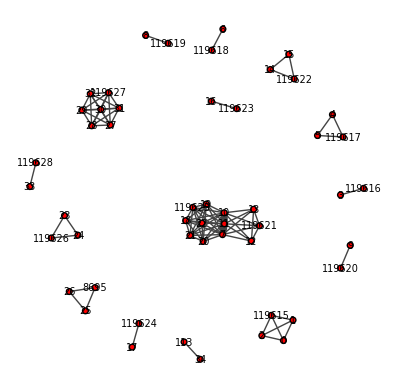

In [18]:
#| echo: false
#| output: false
def get_edges_year(year: int) -> pd.DataFrame:
	"""Return weighted edges for all movies released before and on ``year``"""
	return (df_edges
		.query(f'movie_release_year <= {year}')
		.groupby(['actor1_numid', 'actor2_numid'])
		[['movie_fbid']]
		.nunique()
		.reset_index()
		.rename(columns={'movie_fbid': 'movie_count'})
	)

# test the function
random.seed(0)  # seed the random layout
fig, ax = plt.subplots()
g0 = ig.Graph.DataFrame(get_edges_year(years[10])[['actor1_numid', 'actor2_numid', 'movie_count']], directed=False, use_vids=False)
ig.plot(g0, target=ax,
	vertex_label=g0.vs['name'], vertex_label_size=7,
	edge_width=g0.es['movie_count']
);

In [22]:
#| echo : false

#### Run computation
# Note : actors keep their degree even after they die !

if False:  # recompute
	degrees = np.zeros((uniques.nunique(), df_edges.movie_release_year.nunique()))

	for iyear, year in tqdm(enumerate(years), total=len(years)):
		g = ig.Graph.DataFrame(get_edges_year(year)[['actor1_numid', 'actor2_numid', 'movie_count']], directed=False, use_vids=False)
		# print(g.summary())
		for node, k in zip(g.vs, g.degree()):
			degrees[node['name'], iyear] = k
	
	np.savez('../data/generated/graph/network_growth/actor_graph_full_degrees.npz', degrees)

else:  # load from precomputed
	degrees = np.load('../data/generated/graph/network_growth/actor_graph_full_degrees.npz')['arr_0']


delta_degrees = np.diff(degrees, axis=-1)
# k = 0 corresponds to actors not yet born
degrees[degrees == 0] = np.nan
# Delta k = 0 corresponds to actors that don't evolve
delta_degrees[delta_degrees == 0] = np.nan

In [23]:
#| echo: false
# convert the data to a dataframe
df_degree = pd.DataFrame(degrees, columns=years).melt(var_name='year', value_name='k', ignore_index=False)
df_degree.dropna(inplace=True)
df_degree.reset_index(inplace=True, names='actor_numid')

df_delta_degree = pd.DataFrame(delta_degrees, columns=years[:-1]).melt(var_name='year', value_name='dk', ignore_index=False)
df_delta_degree.dropna(inplace=True)
df_delta_degree.reset_index(inplace=True, names='actor_numid')

df_pref_attachment_delta = pd.merge(df_delta_degree, df_degree, how='inner', on=['actor_numid', 'year'])

In [24]:
#| echo: false
#| output: false
df_pref_attachment_delta

,actor_numid,year,dk,k
0,7,1898,4.0,1.0
1,12,1898,4.0,1.0
2,7,1901,6.0,5.0
3,11,1901,6.0,5.0
4,12,1901,6.0,5.0
...,...,...,...,...
195683,51342,2015,1.0,149.0
195684,52861,2015,4.0,57.0
195685,61062,2015,1.0,114.0
195686,73797,2015,1.0,51.0


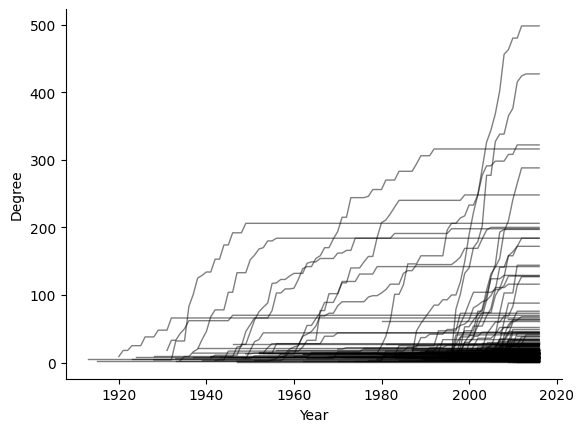

In [30]:
#| echo: false
#| fig-cap: Actor degree as a function of time. Each line models one actor. This figure shows only a random sample of 256 actors to give a general impression and to avoid cluttering the plot.
#| label: fig-degev

fig, ax = plt.subplots()
np.random.seed(0)
# we plot only 256 actors because plotting all 1.3M of them would take ages !!
ax.plot(years, degrees[np.random.randint(0, len(degrees), 256)].T, color='black', alpha=0.5, linewidth=1)
ax.set_xlabel('Year')
ax.set_ylabel('Degree')
# ax.set_title('Actor degree as a function of time')
plt.show()

In @fig-deltadeg, we plot a 2D histogram of the degree evolution $\Delta k_i$ versus the original degree $k_i$. Darker colours correspond to a higher density of samples. If there were no preferential attachement, that is $\Pi = \textrm{constant}$, we would expect that $\Delta k_i$ be intependant of $k_i$. However, the general trend of this figure shows that the higher the original degree $k_i(t)$, the more the degree grows to $k_i(t+1) = k_i(t) + \Delta k_i(t)$, which shows that this network exhibits preferential attachment. And in accordance with @fig-degev, we see that this preferential attachment is stronger when actors join the graph later.

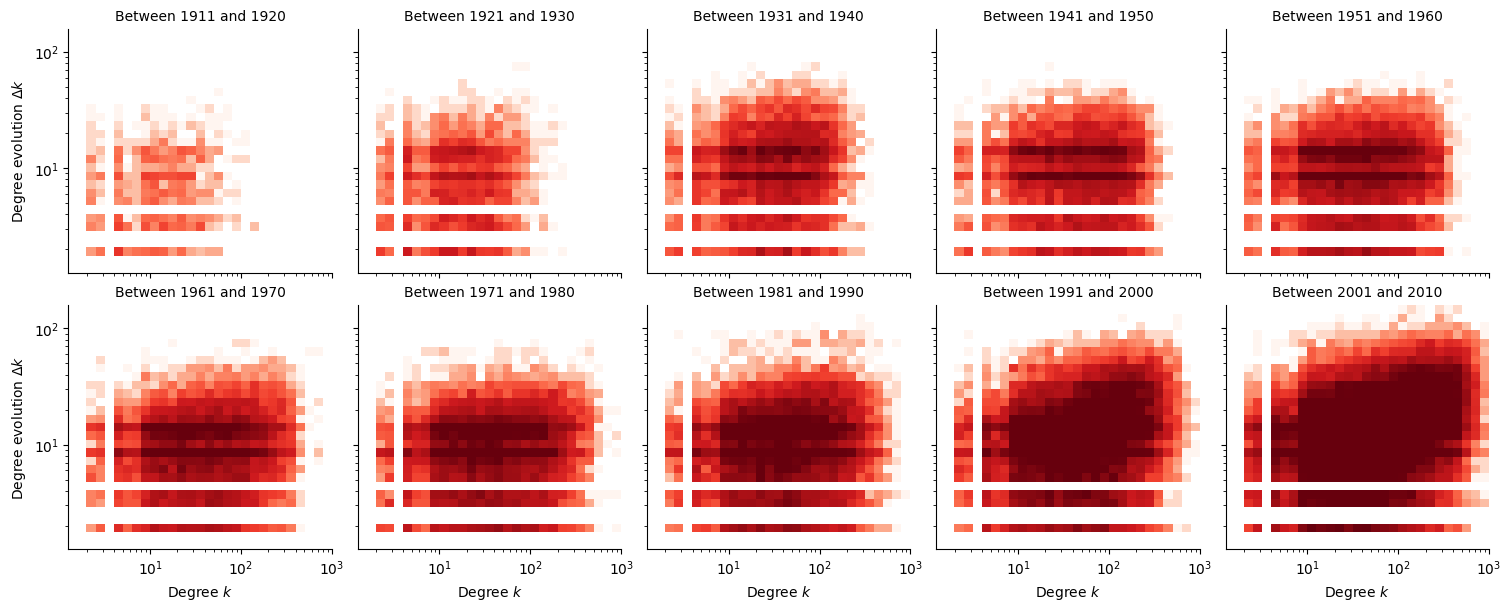

In [42]:
#| echo: false
#| label: fig-deltadeg
#| fig-cap: Preliminary evidence of preferential attachment through degree evolution. This figure shows degree evolution $\Delta k_i$ as a function of degree $k_i$, binned every decade starting 1911.
#| column: screen-inset

fig, axs = plt.subplots(figsize=(5*3, 2*3), ncols=5, nrows=2, sharex=True, sharey=True, constrained_layout=True)

df_pref_attachment_delta['year_bin'] = pd.cut(df_pref_attachment_delta.year, range(1910, 2010+1, 10))

for (year_bin, df_pref_attachment_delta_bin), ax in zip(df_pref_attachment_delta.groupby('year_bin'), axs.flat):
	# ax.plot(df_pref_attachment_delta_bin.k, df_pref_attachment_delta_bin.dk, '.', markersize=2, alpha=0.2)
	ax.hist2d(
		df_pref_attachment_delta_bin.k, df_pref_attachment_delta_bin.dk,
		bins=[np.logspace(0.1, 3, 30), np.logspace(0.1, 2.2, 30)], norm='log', vmin=1, vmax=100, cmap='Reds'
	)
	# NOTE : we don't use year_bin.right because then we get "From 2011 to 2020" 
	ax.set_title(f'Between {year_bin.left+1} and {df_pref_attachment_delta_bin.year.max()}', fontsize='medium')
	ax.set_xscale('log')
	ax.set_yscale('log')
	ax.set_xlabel('Degree $k$')
	ax.set_ylabel('Degree evolution $\\Delta k$')
	ax.label_outer()

# fig.suptitle('Preliminary evidence of preferential attachment through degree evolution')

plt.show()

## Computing the preferential attachment exponent

### Methodology

In order to formalize the results of the previous section, we compute the preferential attachment factor based on the methods explained in [@jeong_2003].

For the following, we consider adding edges to the graph progressively. If the edge adds a new actor to the network ("external edge"), we record the degree of the actors it attaches to. Note that we therefore do not report the degrees between two existing actors ("internal edges"), but we still add them progressively.

We want to estimate :

$$\Pi(k_i) = \frac{k_i}{\sum_j k_j} \approx \frac{\text{number of new connections to node } i}{\text{total number of new connections}}$$

Numerically, we perform this by histogramming. Therefore, the algorithm is as follows :

1. Since we need an already existing population in order to estimate preferential attachment, we consider the initial graph at time $t_0 = 1920$.
2. Bin edges together based on their date.
3. For each bin $(t_-, t_+)$, repeat :
   1. Record the degree histogram $p(k)$ at the start $t_-$ of each bin.
   2. Add the edges in the bin, and record the degree histogram $q(k)$ of the actors that new actors connect to.
   3. The probability distribution $\Pi(k)$ is obtained by dividing $q(k)$ by $p(k)$, and renormalizing. The denominator accounts for the fact that high degrees are more rare. If we didn't perform this division, then we would observe little preferential attachment, as new actors connect to many low degree actors just due to the sheer number of them.

We perform binning using two methods, and plot the bin sizes in @fig-bin. Binning edges together every decade gives us more control over the date at which we perform the estimation, but yields very uneven bin sizes. Binning edges together every 9th quantile (but rounding at integer years) yields more even bin sizes, but the dates are non-uniformly distributed.

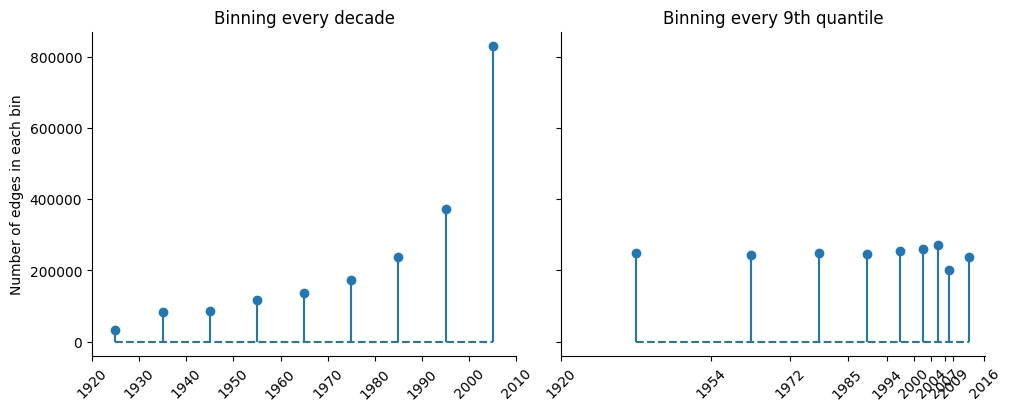

In [88]:
#| echo: false
#| fig-cap: Sample sizes for the two edge binning methods
#| label: fig-bin

df_year_bin_count = df_edges.groupby('year_bin')[['actor1_fbid']].count().rename(columns={'actor1_fbid': 'nb'})
df_year_bin_count.index = pd.IntervalIndex(df_year_bin_count.index)
df_year_qbin_count = df_edges.groupby('year_qbin')[['actor1_fbid']].count().rename(columns={'actor1_fbid': 'nb'})
df_year_qbin_count.index = pd.IntervalIndex(df_year_qbin_count.index)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharey=True, constrained_layout=True)
ax[0].stem(df_year_bin_count.index.mid.values, df_year_bin_count.nb, basefmt='--')
# ax[0].set_xticks(df_year_bin_count.index.left)
ax[1].stem(df_year_qbin_count.index.mid.values, df_year_qbin_count.nb, basefmt='--')

ax[0].set_xticks(list(df_year_bin_count.index.left.values.astype(int)) + [ df_year_bin_count.index.values[-1].right ])
ax[0].set_xticklabels(ax[0].get_xticks(), rotation=45)
ax[1].set_xticks(list(df_year_qbin_count.index.left.values.astype(int)) + [ int(df_year_qbin_count.index.values[-1].right) ])
ax[1].set_xticklabels(ax[1].get_xticks(), rotation=45)

ax[0].set_title('Binning every decade')
ax[1].set_title('Binning every 9th quantile')

ax[0].set_ylabel('Number of edges in each bin')

plt.show()

### Numerical results

In [89]:
#| echo: false

if False:  # recompute
	for binning_method in ['year_bin', 'year_qbin']:
		g = ig.Graph.DataFrame(df_edges.query('movie_release_year <= 1920')[['actor1_fbid', 'actor2_fbid']], directed=False, use_vids=False)
		pa_internal = []
		pa_external = []
		degree_distribution = {}

		for bin, df_edges_bin in tqdm(df_edges.query('1920 < movie_release_year').groupby(binning_method, sort=False)):
			degrees = g.degree()
			degree_lookup = dict(zip([ v['name'] for v in g.vs ], degrees))
			degree_distribution[bin] = pd.Series(degrees).value_counts(normalize=True).sort_index()
			new_actors = set()

			for _, edge in df_edges_bin.iterrows():
				actor1_degree = degree_lookup.get(edge.actor1_fbid, 0)
				actor2_degree = degree_lookup.get(edge.actor2_fbid, 0)
				
				if actor1_degree == 0:
					new_actors.add(edge.actor1_fbid)
				if actor2_degree == 0:
					new_actors.add(edge.actor2_fbid)

				# both added at the same time. ignore
				if actor1_degree == 0 and actor2_degree == 0:
					continue

				# external edge
				if actor1_degree == 0 and actor2_degree > 0:
					pa_external.append((actor2_degree, bin))
				if actor1_degree > 0 and actor2_degree == 0:
					pa_external.append((actor1_degree, bin))

				# internal edge
				if actor1_degree > 0 and actor2_degree > 0:
					pa_internal.append((actor1_degree*actor2_degree, bin))

			g.add_vertices(list(new_actors))
			g.add_edges(zip(df_edges_bin.actor1_fbid, df_edges_bin.actor2_fbid))

		df_pa_external = pd.DataFrame(pa_external, columns=['k', 'bin'])
		df_pa_internal = pd.DataFrame(pa_internal, columns=['k1k2', 'bin'])
		df_degree_distribution = (pd.DataFrame(degree_distribution)
			.melt(var_name='bin', value_name='p_k', ignore_index=False)
			.reset_index(names='k')
			.dropna()
		)

		if True:  # save to disk
			df_pa_external.to_pickle(f'../data/generated/graph/network_growth/pa_external_{binning_method}.pkl')
			df_pa_internal.to_pickle(f'../data/generated/graph/network_growth/pa_internal_{binning_method}.pkl')
			df_degree_distribution.to_pickle(f'../data/generated/graph/network_growth/degree_distribution_{binning_method}.pkl')


df_pa_external_year_bin = pd.read_pickle('../data/generated/graph/network_growth/pa_external_year_bin.pkl')
df_pa_internal_year_bin = pd.read_pickle('../data/generated/graph/network_growth/pa_internal_year_bin.pkl')
df_degree_distribution_year_bin = pd.read_pickle('../data/generated/graph/network_growth/degree_distribution_year_bin.pkl')
df_pa_external_year_qbin = pd.read_pickle('../data/generated/graph/network_growth/pa_external_year_qbin.pkl')
df_pa_internal_year_qbin = pd.read_pickle('../data/generated/graph/network_growth/pa_internal_year_qbin.pkl')
df_degree_distribution_year_qbin = pd.read_pickle('../data/generated/graph/network_growth/degree_distribution_year_qbin.pkl')

In [91]:
#| echo: false
# assert the distributions are correctly normalized
assert (df_degree_distribution_year_bin.groupby('bin').p_k.sum() > 0.999).all()
assert (df_degree_distribution_year_qbin.groupby('bin').p_k.sum() > 0.999).all()

In [92]:
#| echo: false
#| output: false
# inspect dataframe
df_degree_distribution_year_bin

,k,bin,p_k
0,1,"(1920, 1930]",0.060832
1,2,"(1920, 1930]",0.045526
2,3,"(1920, 1930]",0.055338
3,4,"(1920, 1930]",0.069859
4,5,"(1920, 1930]",0.062402
...,...,...,...
6148,1117,"(2000, 2010]",0.000012
6150,1143,"(2000, 2010]",0.000012
6151,1233,"(2000, 2010]",0.000012
6154,1339,"(2000, 2010]",0.000012


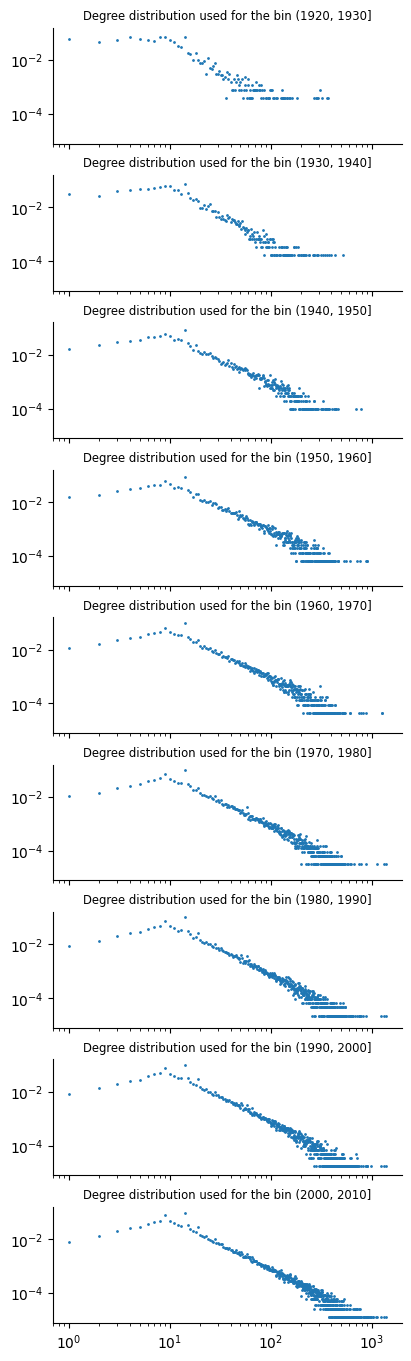

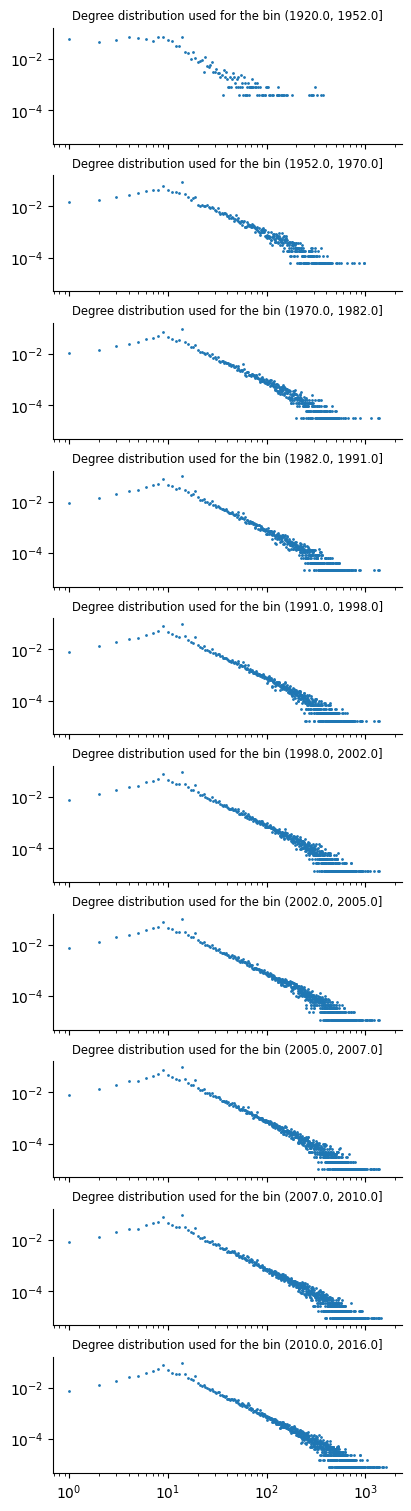

In [93]:
#| echo: false
#| output: false

for df_degree_distribution in [df_degree_distribution_year_bin, df_degree_distribution_year_qbin]:
	fig, axs = plt.subplots(figsize=(4, df_degree_distribution.bin.nunique()*1.5),
		nrows=df_degree_distribution.bin.nunique(), sharex=True, sharey=True, constrained_layout=True)
	for (bin, df_degree_distribution_bin), ax in zip(df_degree_distribution.groupby('bin'), axs.flat):
		ax.plot(df_degree_distribution_bin.k, df_degree_distribution_bin.p_k, '.', markersize=2)
		ax.set_xscale('log')
		ax.set_yscale('log')
		ax.label_outer()
		ax.set_title(f'Degree distribution used for the bin {bin}', fontsize='small')
	plt.show() 

In [94]:
#| echo: false

def compute_pi_kappa(df_pa_external, df_degree_distribution):
	pi_external = (
		df_pa_external.groupby('bin')
		.k.value_counts(normalize=True)  # histogram of edge connections as a function of k
		.sort_index()
		.rename('pi')  # distribution of edge connections
	)
	for bin in df_pa_external.bin.unique():
		# we need to divide by the distribution of edges,
		# because otherwise the histogram is biased toward the more frequent degrees
		pi_external[bin] /= (
			df_degree_distribution.query('bin == @bin')  # the distribution of degrees right before the bin of edges was added
			.set_index('k').p_k
		)
		# normalize
		pi_external[bin] /= pi_external[bin].sum()

	# compute cumulative sum
	kappa_external = pi_external.groupby('bin').cumsum().rename('kappa')

	pi_external = pi_external.reset_index()
	kappa_external = kappa_external.reset_index()

	return pi_external, kappa_external

The Barabási-Albert model can be extended to other regimes of preferential attachment. [@jeong_2003] defines the scaling exponent $\alpha$ as :

$$
\Pi(k) \sim k^\alpha
$$

If $\alpha = 1$, we recover the original Barabási-Albert model (linear preferential attachment). Regimes $\alpha < 1$ are said to be sub-linear, and $\alpha > 1$ is super-linear. Larger values of $\alpha$ therefore correspond to a stronger preferential attachment, and one can intuitively expect the appearance of giant hubs.

Performing the computations, we scatter the results for $\Pi(k)$ in @fig-pacum. While it is clear that preferential attachment follows a power law, there is a lot of noise in the data. To address this, the paper suggests to use the cumulative function :

$$
\kappa(k) = \int^k \Pi(k') \; \mathrm d k' \sim k^{\alpha+1}
$$

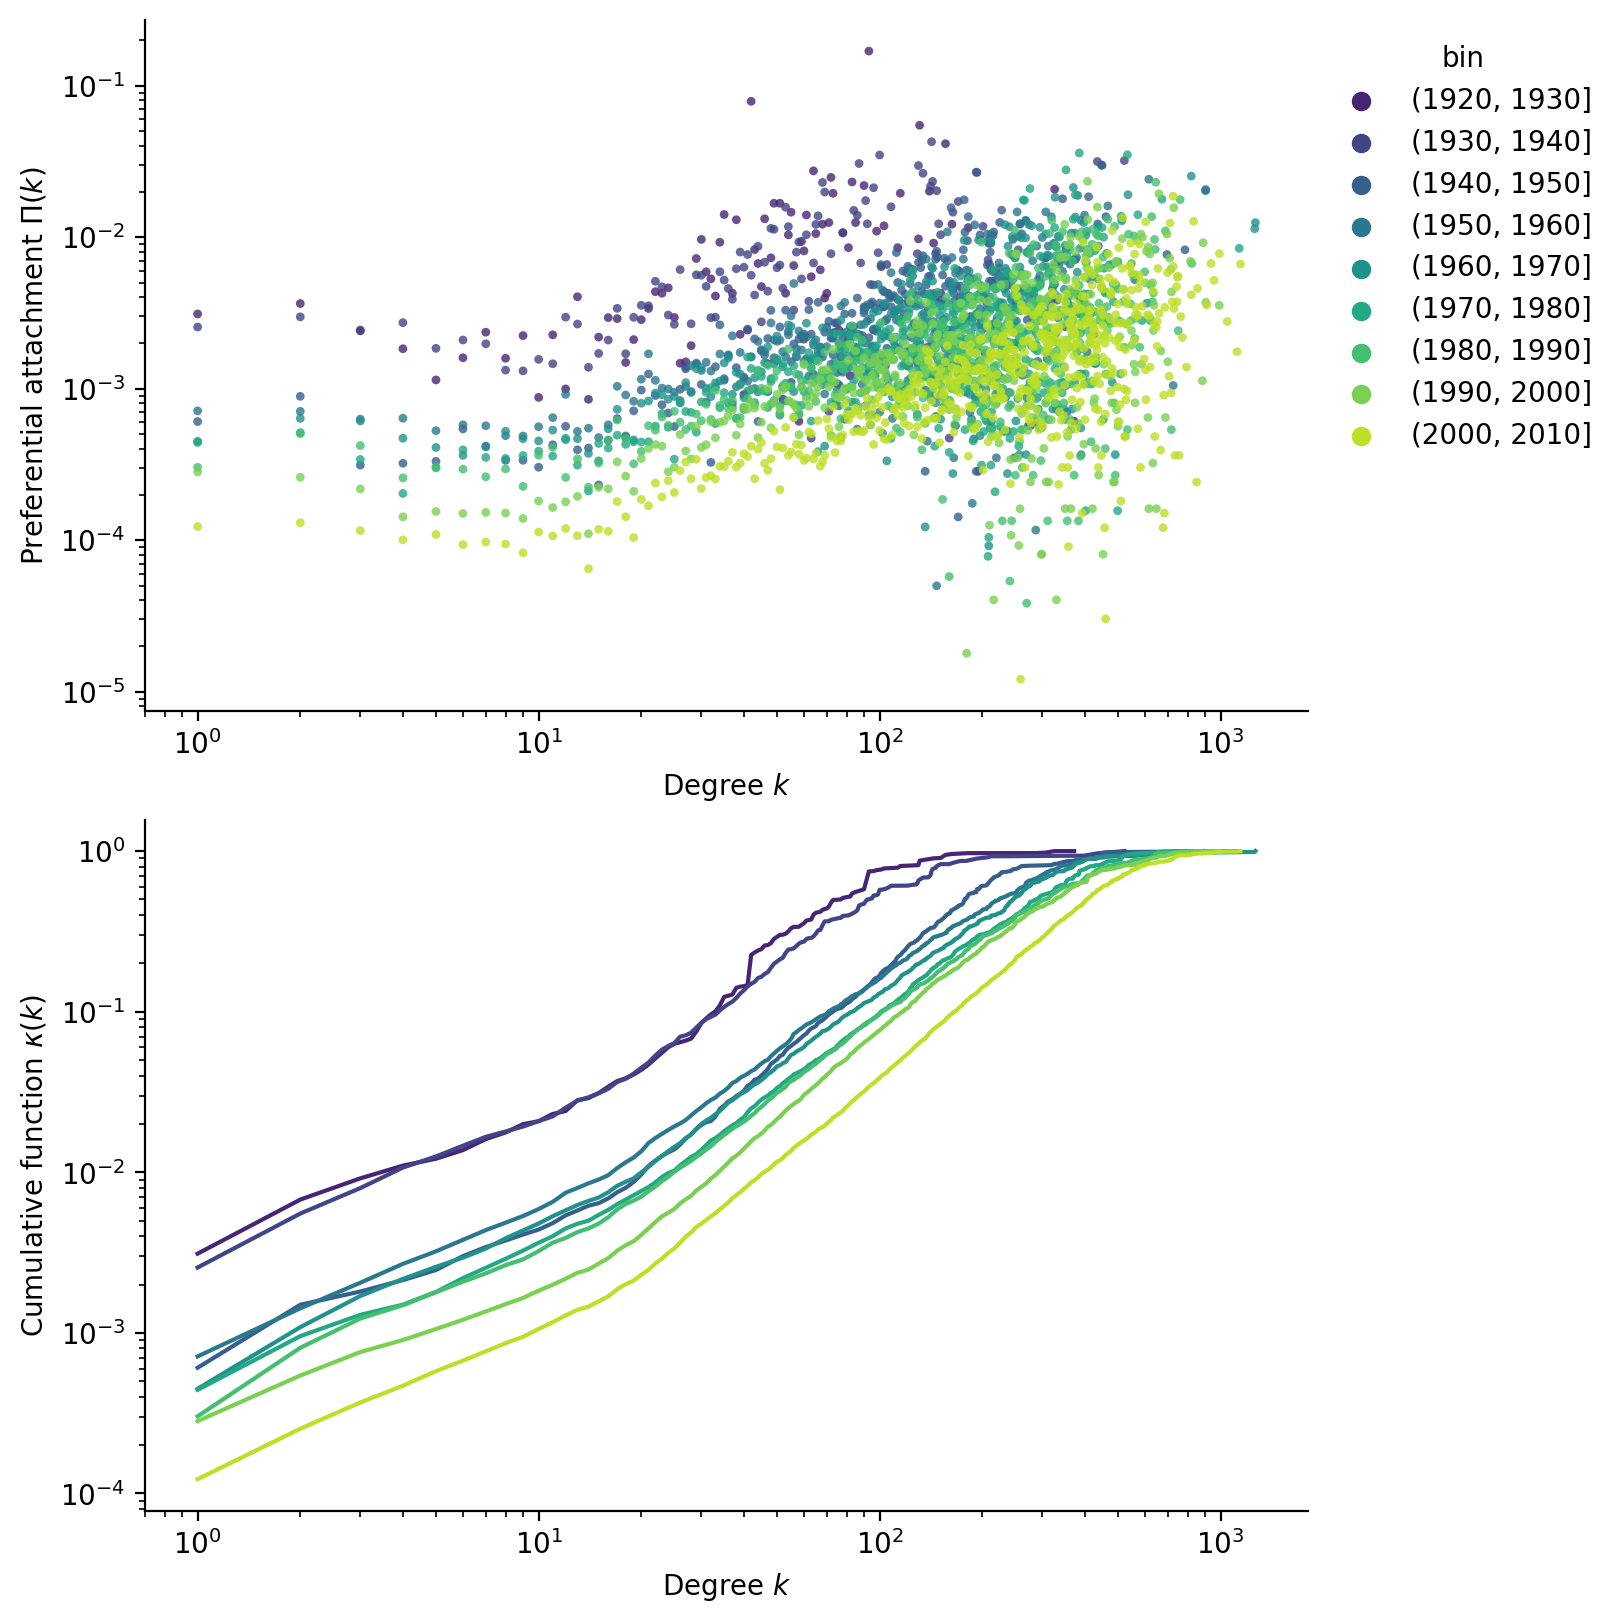

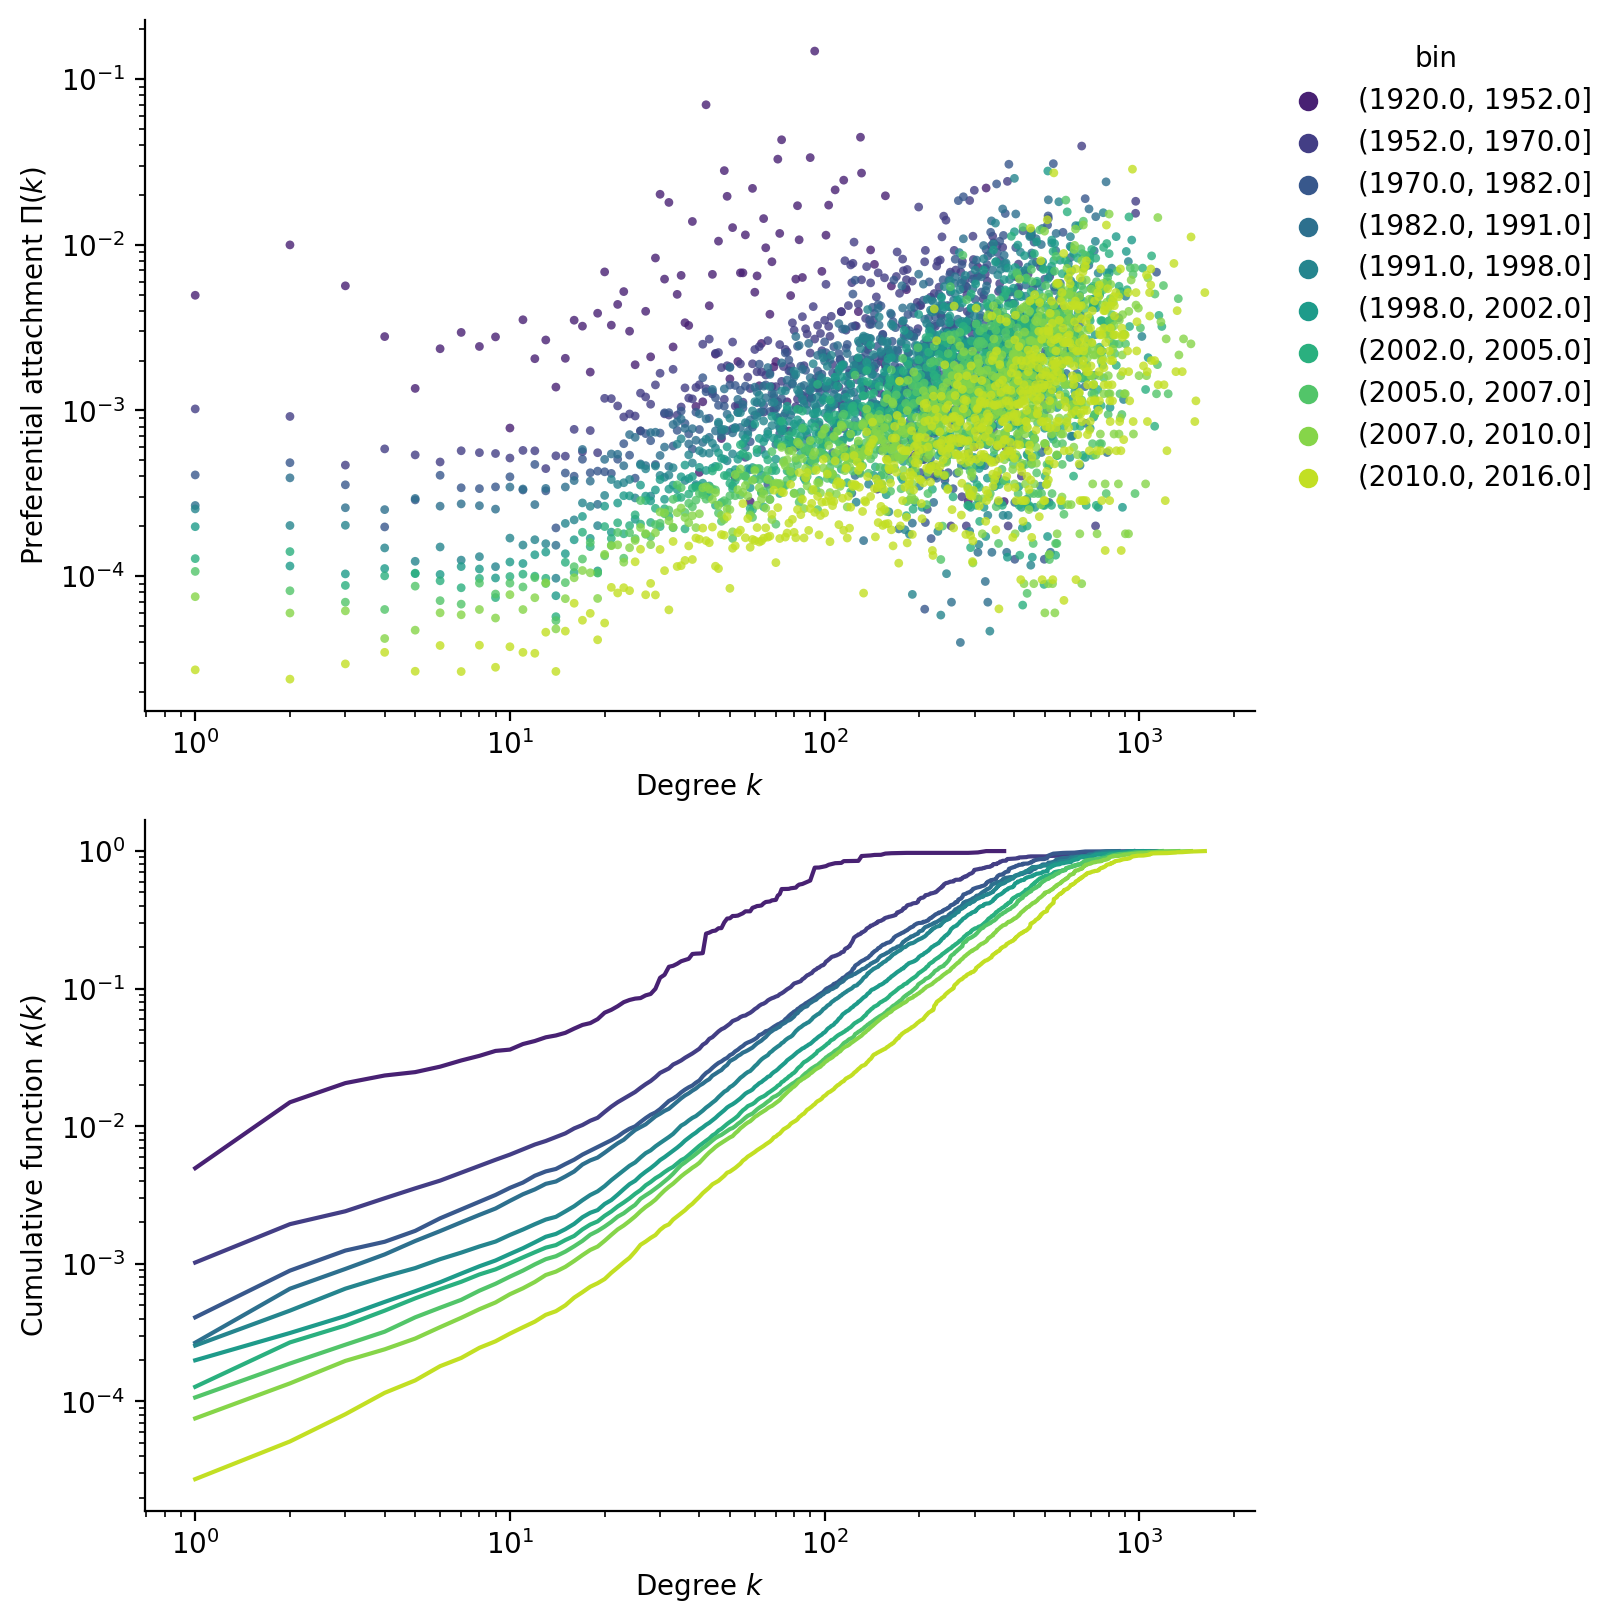

In [98]:
#| echo: false
#| fig-cap: Preferential attachment $\Pi(k)$ and cumulative function $\kappa(k)$ for the two binning methods.
#| fig-subcap:
#|   - Binning every decade
#|   - Binning every 9th quantile
#| layout-ncol: 2
#| column: screen-inset
#| label: fig-pacum

for df_pa_external, df_degree_distribution in [(df_pa_external_year_bin, df_degree_distribution_year_bin), (df_pa_external_year_qbin, df_degree_distribution_year_qbin)]:
	pi_external, kappa_external = compute_pi_kappa(df_pa_external, df_degree_distribution)

	fig, axs = plt.subplots(nrows=2, figsize=(8, 8), constrained_layout=True, dpi=200)

	sns.scatterplot(pi_external, x='k', y='pi', hue='bin', linewidth=0, alpha=0.8, s=10, palette='viridis', ax=axs[0])
	sns.move_legend(axs[0], loc='upper left', bbox_to_anchor=(1, 1))
	axs[0].set_ylabel('Preferential attachment $\\Pi(k)$')
	axs[0].set_xlabel('Degree $k$')
	axs[0].set_yscale('log')
	axs[0].set_xscale('log')
	# axs[0].set_title('Preferential attachment by year bin')

	sns.lineplot(kappa_external, x='k', y='kappa', hue='bin', palette='viridis', legend=False, ax=axs[1])
	# sns.move_legend(axs[1], loc='lower right', fontsize='small')
	axs[1].set_ylabel('Cumulative function $\\kappa(k)$')
	axs[1].set_xlabel('Degree $k$')
	axs[1].set_yscale('log')
	axs[1].set_xscale('log')
	# axs[1].set_title('Cumulative function by year bin')

	plt.show()

In [100]:
#| echo: false

def compute_fitcoefs(df_kappa):
	values = []

	for bin, df_kappa_bin in df_kappa.groupby('bin'):
		if len(df_kappa_bin) >= 2:
			model = smf.ols(formula="log_kappa ~ log_k", data=dict(log_k=np.log10(df_kappa_bin.k), log_kappa=np.log10(df_kappa_bin.kappa)))
			res = model.fit()
			# display(res.summary())
			alpha_plus_one = (res.params['log_k'], *res.conf_int().loc['log_k'])
			values.append((bin, alpha_plus_one[0]-1, alpha_plus_one[1]-1, alpha_plus_one[2]-1))
		else:
			values.append((bin, np.nan, np.nan, np.nan))

	return pd.DataFrame(values, columns=['bin', 'alpha', 'ci_lower', 'ci_upper'])

In [101]:
#| echo: false

fitcoefs = {
	'year_bin': compute_fitcoefs(compute_pi_kappa(df_pa_external_year_bin, df_degree_distribution_year_bin)[1]),
	'year_qbin': compute_fitcoefs(compute_pi_kappa(df_pa_external_year_qbin, df_degree_distribution_year_qbin)[1])
}

In [102]:
#| echo: false
#| output: false

fitcoefs

{'year_bin':             bin     alpha  ci_lower  ci_upper
 0  (1920, 1930]  0.276953  0.210638  0.343267
 1  (1930, 1940]  0.210021  0.169118  0.250924
 2  (1940, 1950]  0.510332  0.476495  0.544169
 3  (1950, 1960]  0.336974  0.318484  0.355464
 4  (1960, 1970]  0.386186  0.366752  0.405619
 5  (1970, 1980]  0.433514  0.417537  0.449490
 6  (1980, 1990]  0.419824  0.405383  0.434265
 7  (1990, 2000]  0.522066  0.502441  0.541692
 8  (2000, 2010]  0.639683  0.624278  0.655087,
 'year_qbin':                 bin     alpha  ci_lower  ci_upper
 0  (1920.0, 1952.0]  0.099836  0.045346  0.154326
 1  (1952.0, 1970.0]  0.333914  0.311530  0.356299
 2  (1970.0, 1982.0]  0.442242  0.426329  0.458155
 3  (1982.0, 1991.0]  0.431424  0.417991  0.444858
 4  (1991.0, 1998.0]  0.547346  0.527997  0.566695
 5  (1998.0, 2002.0]  0.614853  0.597720  0.631986
 6  (2002.0, 2005.0]  0.626947  0.611793  0.642101
 7  (2005.0, 2007.0]  0.670241  0.655415  0.685068
 8  (2007.0, 2010.0]  0.669631  0.658343  0.6

Performing the fit, we report the obtained scaling exponents and their 95% confidence interval in @fig-alphaev. Using the quantile bins, we can also compute an "average exponent" to be around $\alpha \approx 0.5$, putting this network in the sublinear regime. Both binning methods show that the exponent tends to increase with time, confirming the observation that actors grow faster as they enter later into the graph.

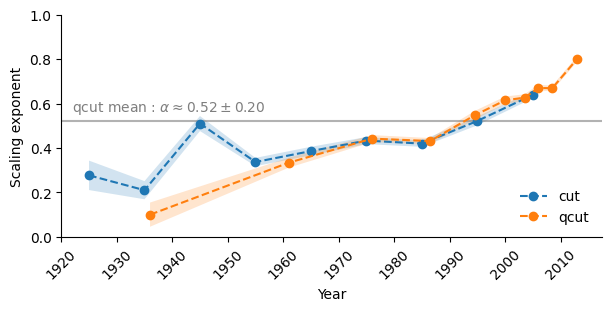

In [105]:
#| echo: false
#| fig-cap: Evolution of scaling exponent $\alpha$.
#| label: fig-alphaev

fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)

mid_years = fitcoefs['year_bin'].bin.map(lambda x: (x.left + x.right)/2)
qmid_years = fitcoefs['year_qbin'].bin.map(lambda x: (x.left + x.right)/2)

alpha_mean, alpha_std = fitcoefs['year_qbin'].alpha.mean(), fitcoefs['year_qbin'].alpha.std()
ax.axhline(alpha_mean, alpha=0.6, color='tab:gray')
ax.annotate(f'qcut mean : $\\alpha \\approx {alpha_mean:.2f} \pm {alpha_std:.2f}$',
	xy=(0.02, alpha_mean+0.02), va='bottom', xycoords=('axes fraction', 'data'), color='tab:gray')
ax.fill_between(mid_years, fitcoefs['year_bin'].ci_lower, fitcoefs['year_bin'].ci_upper, alpha=0.2)
ax.fill_between(qmid_years, fitcoefs['year_qbin'].ci_lower, fitcoefs['year_qbin'].ci_upper, alpha=0.2)
ax.plot(mid_years, fitcoefs['year_bin'].alpha, 'o--', label='cut')
ax.plot(qmid_years, fitcoefs['year_qbin'].alpha, 'o--', label='qcut')

ax.set_xticks([ int(x.left) for x in fitcoefs['year_bin'].bin ] + [ int(fitcoefs['year_bin'].bin.iloc[-1].right) ])
ax.set_xticklabels(ax.get_xticks(), rotation=45)
ax.legend(loc='lower right')

ax.set_xlabel('Year')
ax.set_ylabel('Scaling exponent')

ax.set_ylim((0.0, 1.0))
# ax.set_title('Evolution of preferential attachment exponent, $\\Pi(k) \\sim k^{\\alpha}$')
plt.show()

### Comparing the model to observed results

We now ask whether this model is able to predict the observed degree distribution. In the sub-linear regime, the probability distribution follows a stretched exponential distribution : 

$$
p(k) \sim k^{-\alpha} \exp \left(\frac{-2 k^{1-\alpha}}{\langle k \rangle (1-\alpha)} \right)
$$

@fig-compare compares the predicted and true distributions. Unfortunately, the match is poor : what happened ? When we computed the preferential attachment, recall we ignored internal edges, however they make up about 32% of the total edges, and are therefore not neglectible.

Therefore, we predict that the true exponent must actually be greater than one, putting the model in the super-linear regime. This is further supported by @fig-kmax, in which we see that the largest degree grows roughly linearly, $k_{\text{max}} \sim t$, as one would find on the super-linear regime [@barabasi_2016].

In [106]:
#| echo: false

def p_k_th(alpha: float, k_mean: float):
	def p_k(k: np.ndarray) -> np.ndarray:
		p = k**(-alpha) * np.exp(-2/(k_mean*(1-alpha)) * k**(1-alpha))
		p /= p.sum()
		return p
	return p_k

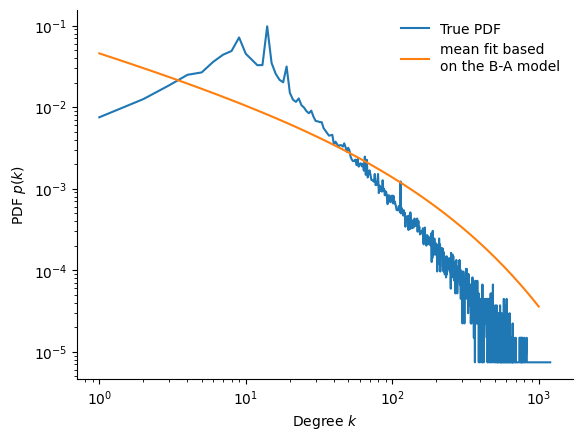

In [108]:
#| echo: false
#| fig-cap: Comparing the true degree distribution to the one predicted by the Barabási-Albert model.
#| label: fig-compare

fig, ax = plt.subplots()

degrees_final = degrees[:, -1].copy()
degrees_final.sort()
pdf = pd.Series(degrees_final).value_counts(normalize=True).sort_index()
ax.plot(pdf.index, pdf.values, label='True PDF')
# sns.histplot(degrees_final, log_scale=(True, True), stat='probability', label='true distribution')

# year_to_idx = { year: i for i, year in enumerate(years) }
# k_means = [ np.nanmean(degrees[:, year_to_idx[int(qmid_year)]]) for qmid_year in qmid_years ]
k = np.logspace(0, 3, 100)
sns.lineplot(x=k, y=p_k_th(fitcoefs['year_qbin'].alpha.mean(), degrees_final.mean())(k),
	label='mean fit based\non the B-A model')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Degree $k$')
ax.set_ylabel('PDF $p(k)$')

ax.legend()
plt.show()

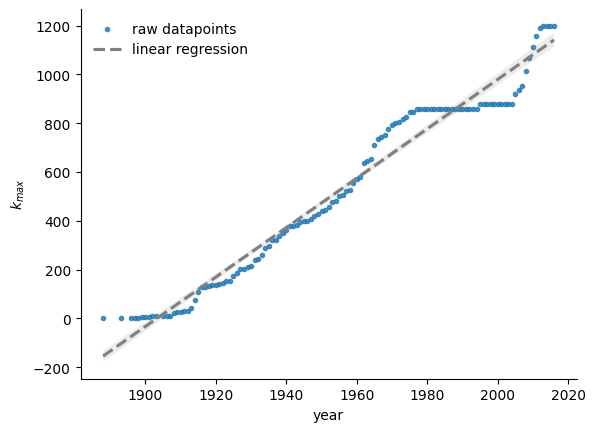

In [128]:
#| echo: false
#| fig-cap: Evolution of the maximum actor network degree
#| label: fig-kmax

kmax = np.nanmax(degrees, axis=0)
fig, ax = plt.subplots()
# ax.plot(years, kmax)
sns.regplot(x=years, y=kmax, ax=ax, marker='.', line_kws=dict(color='gray', linestyle='--'))
ax.set_xlabel('year')
ax.set_ylabel('$k_{max}$')
ax.legend(['raw datapoints', 'linear regression'])
# ax.set_title('Evolution of the maximum actor network degree')
plt.show()

In [130]:
#| echo: false

if False:
	g = ig.Graph(directed=False)
	total_movies = 0
	components = []

	for year, df_edges_year in tqdm(df_edges.groupby('movie_release_year', sort=False)):
		current_actors = set([ v['name'] for v in g.vs ])
		actors_from_edges = set(df_edges_year.actor1_fbid.unique()) | set(df_edges_year.actor2_fbid.unique())
		new_actors = actors_from_edges - current_actors

		g.add_vertices(list(new_actors))
		g.add_edges(zip(df_edges_year.actor1_fbid, df_edges_year.actor2_fbid))

		total_movies += df_edges_year.movie_fbid.nunique()
		components.append((len(g.connected_components(mode='weak')), total_movies, year))

	df_components = pd.DataFrame(components, columns=['num_connected', 'num_movies', 'year'])

	if True:  # save to disk
		df_components.to_pickle('../data/generated/graph/network_growth/components.pkl')

else:
	df_components = pd.read_pickle('../data/generated/graph/network_growth/components.pkl')

In [134]:
#| echo: false
# #| fig-cap: Growth of components and of the number of movies
# #| label: fig-comp

# # at the start, every movie adds a new unique component, then the clusters start to appear !
# fig, ax = plt.subplots()
# ax.plot(df_components.year, df_components.num_connected, label='number of connected components')
# ax.plot(df_components.year, df_components.num_movies, label='number of movies')
# ax.set_yscale('log')
# ax.set_xlabel('Year')
# ax.legend()
# plt.show()